# 2022-07-05 • Trying for wide

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

In [5]:
p = get_params(duration=10*minutes);
# dumps(p)

## Run sim

In [10]:
s = cached(sim, [p.sim]);

Uncached output:
```
Running simulation: 100%|███████████████████████████████| Time: 0:05:46
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\24d9de18b7c371f6.jld2` … done (15.2 s)
```

In [11]:
import PyPlot

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


In [12]:
using VoltoMapSim.Plot

In [13]:
tlim = @. 3minutes + [0,10]seconds;
tlim = [0,10]seconds;

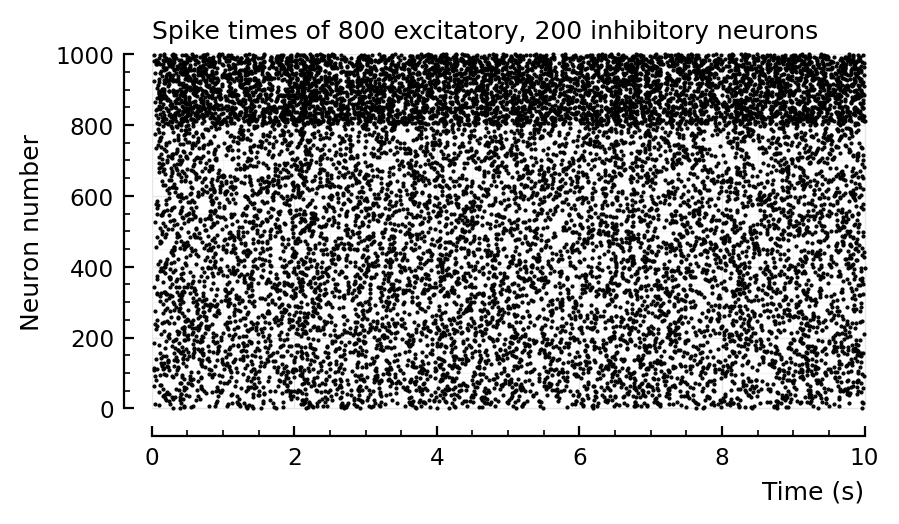

In [52]:
rasterplot(s.spike_times; tlim);

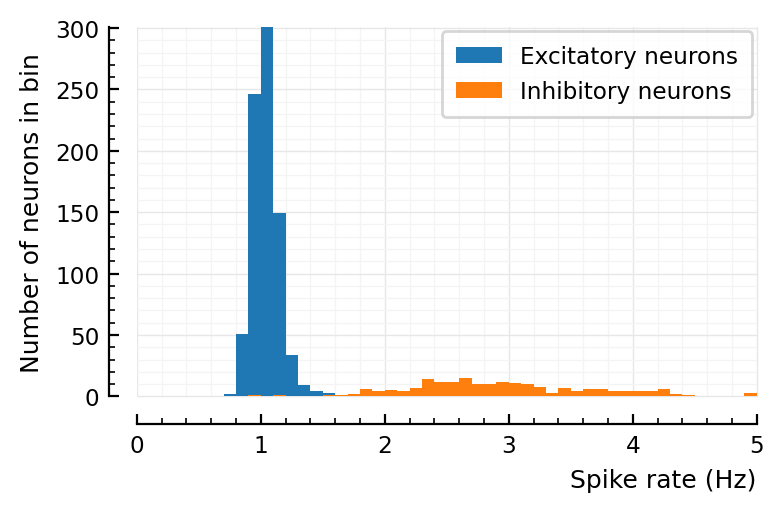

In [15]:
num_spikes = length.(s.spike_times)
spike_rates = num_spikes ./ p.sim.general.duration
fig, ax = plt.subplots()
M = round(Int, maximum(spike_rates))
bins = 0:0.1:M
xlim = (0, M)
ax.hist(spike_rates.exc; bins, label="Excitatory neurons")
ax.hist(spike_rates.inh; bins, label="Inhibitory neurons")
# ax.text(2.2, 80, "Excitatory", c=as_mpl_type(color_exc))
# ax.text(5.2, 30, "Inhibitory", c=as_mpl_type(color_inh))
ax.legend()
set(ax, xlabel="Spike rate (Hz)", ylabel="Number of neurons in bin"; xlim);

In [16]:
VI_sigs = add_VI_noise(s.voltage_traces, p);

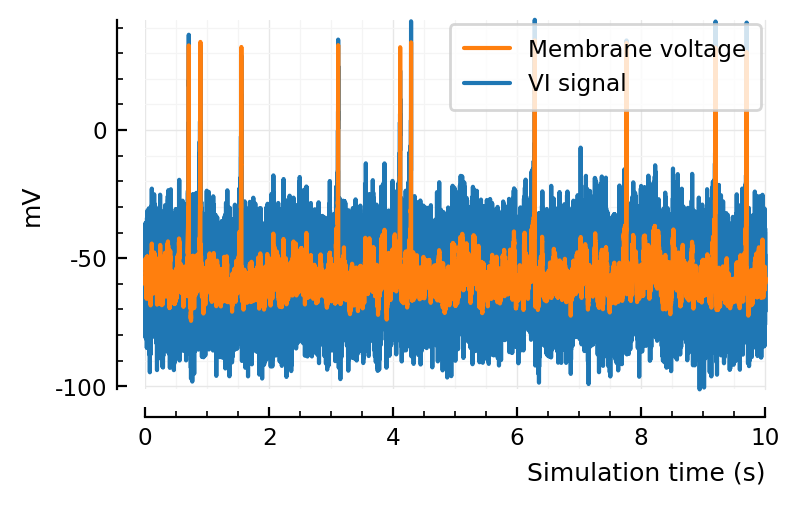

In [17]:
ax = plotsig(s.timesteps, VI_sigs[1] / mV; tlim, label="VI signal");
ax = plotsig(s.timesteps, s.voltage_traces[1] / mV; tlim, ax, label="Membrane voltage")
legend(ax, reorder=[2=>1])
set(ax, xlabel="Simulation time (s)", ylabel="mV");

## Connection test

In [18]:
trace_ID = 1
VI_sig = VI_sigs[trace_ID];
v = s.voltage_traces[trace_ID];

In [19]:
analyzed_neuron = s.recorded_neurons[trace_ID]  # neuron ID

469

In [20]:
input_neurons = s.input_neurons[analyzed_neuron]
length(input_neurons)

98

In [21]:
input_neurons_by_type = CVec(exc=[n for n in input_neurons if s.neuron_type[n] == :exc],
                             inh=[n for n in input_neurons if s.neuron_type[n] == :inh])

ComponentVector{Int64}(exc = [4, 11, 12, 21, 31, 71, 80, 83, 85, 93  …  729, 747, 757, 759, 769, 775, 781, 782, 786, 790], inh = [807, 808, 826, 828, 833, 839, 846, 850, 870, 879  …  906, 910, 917, 918, 932, 940, 948, 963, 992, 994])

In [22]:
length(input_neurons_by_type.exc),
length(input_neurons_by_type.inh)

(75, 23)

In [23]:
unconnected_neurons = [n for n in s.neuron_IDs if n ∉ input_neurons && n != analyzed_neuron];
length(unconnected_neurons)

901

Calc and plot STA of some excitatory inputs (first row) and inhibitory inputs (second row).

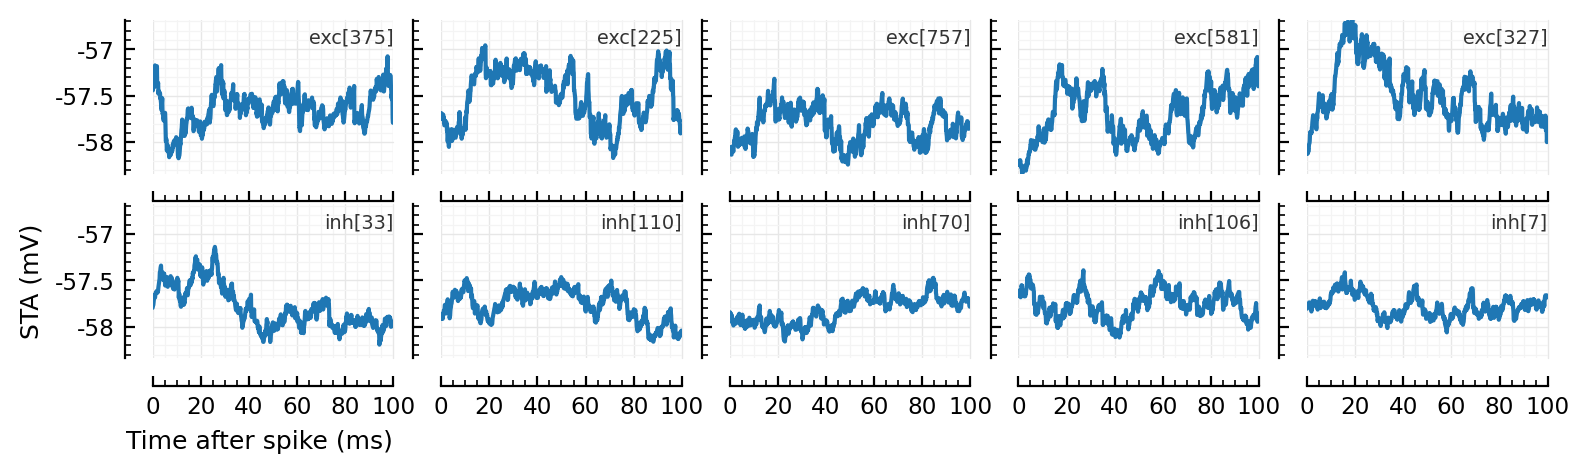

In [49]:
function plot_some_STAs()
    (nrows, ncols) = (2, 5)
    fig, axs = plt.subplots(; nrows, ncols, figsize=(9, 2.2), sharex=true, sharey=true)
    exc = sample(input_neurons_by_type.exc, ncols, replace=false)
    inh = sample(input_neurons_by_type.inh, ncols, replace=false)
    names = labels(s.neuron_IDs)
    for r in 1:nrows
        for c in 1:ncols
            ax = axs[r, c]
            n = (r == 1) ? exc[c] : inh[c]
            plotSTA(v, s.spike_times[n], p; ax, xlabel=nothing, hylabel=(names[n], :dy=>-10, :loc=>:right))
            ax.hylabel.set_fontsize("x-small")
            ax.hylabel.set_color(as_mpl_type(Gray(0.2)))
        end
    end
    set(axs[nrows,1], xlabel="Time after spike (ms)", ylabel="STA (mV)")
end
plot_some_STAs()

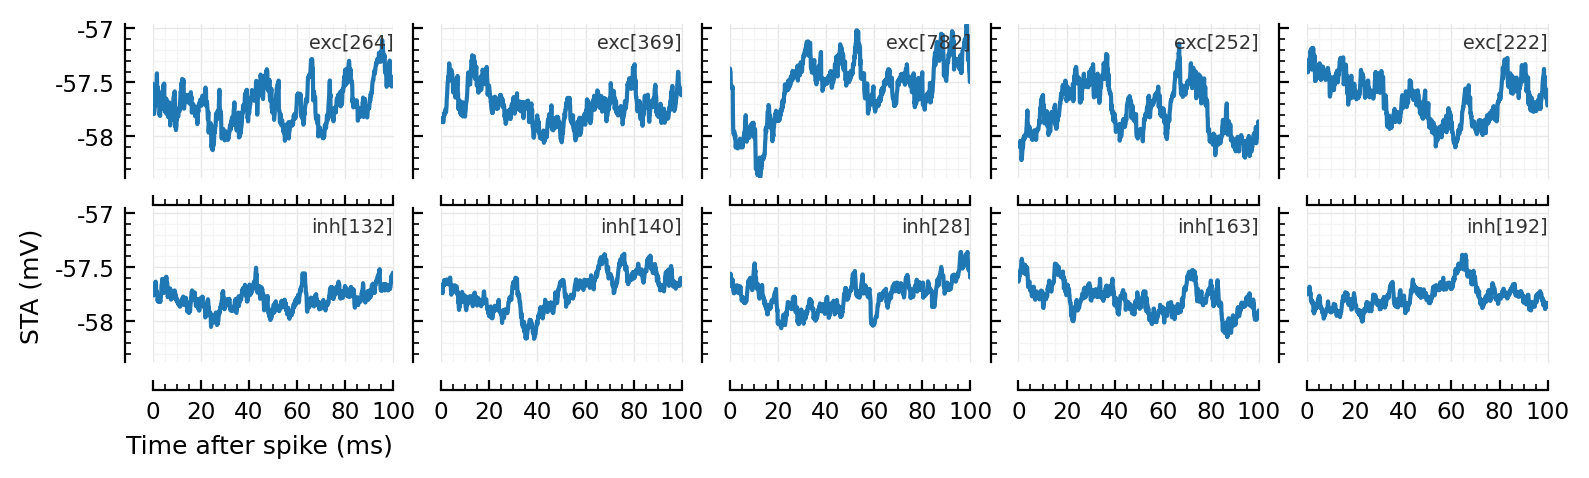

In [50]:
plot_some_STAs()

In [42]:
spiketrains_by_type = (;
    conn = (;
        exc = [s.spike_times[n] for n in input_neurons_by_type.exc],
        inh = [s.spike_times[n] for n in input_neurons_by_type.inh],
    ),
    unconn = [s.spike_times[n] for n in unconnected_neurons],
);

In [45]:
perf = evaluate_conntest_perf(v, spiketrains_by_type, p)

Testing connections: 100%|██████████████████████████████| Time: 0:00:28


(TPR_exc = 0.275, TPR_inh = 0.043478260869565216, FPR = 0.025000000000000022, p_values = (conn = (exc = Any[0.01, 0.33, 0.05, 0.65, 0.39, 0.48, 0.03, 0.11, 0.17, 0.76  …  0.16, 0.9, 0.01, 0.92, 0.01, 0.57, 0.35, 0.39, 0.12, 0.01], inh = Any[0.46, 0.18, 0.29, 0.43, 0.11, 0.36, 0.39, 0.57, 0.18, 0.95  …  0.76, 0.6, 0.01, 0.82, 0.95, 0.12, 0.71, 0.64, 0.28, 0.22]), unconn = Any[0.12, 0.76, 0.83, 0.22, 0.46, 0.99, 0.69, 0.2, 0.51, 0.78  …  0.56, 0.78, 0.96, 0.86, 0.41, 0.49, 0.32, 0.83, 0.53, 0.23]))